## Work Force Development
- Authors: Ronan Doorley
- Ajusments: Parfait Atchade
- Dept: City Science
- Cambridge: 09/18/2024

In [ ]:
import sys
sys.path.append('../../')
import jobmap

In [15]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
BLS_data_loc='data/BLS/oesm21all/all_data_M_2021.xlsx'

In [19]:
soc_map=jobmap.get_soc_code_map('data/BLS/soc_2018_definitions.xlsx')

In [20]:
with open('data/epa_geoids.json') as f:
    epa_geoids=json.load(f)

# Load the population and trips from Replica
includes all people who live and/or work in EPA and al the trips they make on an average weekday

In [21]:
def get_trips_pop(keep_cols):
    with open('data/replica_epa_pop_soc.json') as f:
        trips = json.load(f)
    trips_df=pd.DataFrame.from_dict(trips)[keep_cols]
    trips_df=trips_df.dropna(subset=['soc', 'BLOCKGROUP', 'BLOCKGROUP_work']).copy()
    for col in ['BLOCKGROUP', 'BLOCKGROUP_work']:
        trips_df[col]=trips_df[col].astype(int)
    # identify type of commuter
    trips_df.loc[trips_df['BLOCKGROUP'].isin(epa_geoids), 'Commuter Type']='Out Commuter'
    trips_df.loc[trips_df['BLOCKGROUP_work'].isin(epa_geoids), 'Commuter Type']='In Commuter'
    trips_df.loc[((trips_df['BLOCKGROUP_work'].isin(epa_geoids))&
                  (trips_df['BLOCKGROUP'].isin(epa_geoids))), 'Commuter Type']='Live-Work'    
    
    pop_df=trips_df[['person_id', 'BLOCKGROUP', 'BLOCKGROUP_work', 'BLOCKGROUP_school',
           'individual_income', 'industry', 'soc', 'Commuter Type']].drop_duplicates(subset=['person_id'])
    return trips_df, pop_df

In [22]:
trips_df, pop_df=get_trips_pop(keep_cols=['person_id','BLOCKGROUP', 'BLOCKGROUP_work', 'BLOCKGROUP_school',
          'individual_income', 'mode', 'network_link_ids', 'start_local_hour',
          'industry', 'soc', 'distance_miles', 'travel_purpose','tour_type'])

# Workforce simulation

In [23]:
soc_code_map=jobmap.get_soc_code_map('data/BLS/soc_2018_definitions.xlsx')
state_code='CA'
bls_data=pd.read_excel('data/BLS/oesm21all/all_data_M_2021.xlsx')
job_map=jobmap.JobMap(state_code='CA', bls_data=bls_data)

In [24]:
job_trans=jobmap.JobTransitioner()

# Simulate the job transitions

In [25]:
def job_sim(soc_dict):
    job_list=job_map.get_job_list(soc_dict)
    jobs_df=pd.DataFrame(job_list)
    print('Number of jobs created: {}'.format(len(jobs_df)))
    sample_rate=1

    candidates=pop_df.loc[pop_df['is_resident']].sample(frac=sample_rate).reset_index(drop=True)

    if len(jobs_df)>0:
        print('Creating SOC mat jobs')
        soc_mat_jobs=job_trans.soc_list_to_matrix(jobs_df['soc'].values)

        print('Creating SOC mat candidates')
        soc_mat_candidates=job_trans.soc_list_to_matrix(candidates['soc'].values)

        # identify any job transitions which are infeasible due to lower salary
        salary_decrease=job_trans.get_salary_decrease_mat(
            candidates['individual_income'].astype(float), jobs_df['salary'].astype(float))

        print('Attempting to match {} jobs from {} local candidates'.format(
            len(jobs_df), len(candidates)))

        transitions=job_trans.match_jobs(
            from_soc_mat=soc_mat_candidates,  to_soc_mat=soc_mat_jobs, 
            salary_decrease=salary_decrease)
        print('\t Matched {} jobs locally'.format(len(transitions)))

        transitions=transitions.set_index('col_ind', drop=True)

        jobs_assignment=jobs_df.merge(transitions,
                       left_index=True, right_index=True, how='left').rename(
            columns={'soc': 'soc_new', 'salary': 'salary_new'
        })

        jobs_assignment_successful=jobs_assignment.dropna(subset=['row_ind']).copy()
        jobs_assignment_successful['row_ind']=jobs_assignment_successful['row_ind'].astype(int)

        jobs_assignment_successful=jobs_assignment_successful.merge(
            candidates, left_on='row_ind', right_index=True,
            how='left').rename(
            columns={'soc': 'soc_old', 'salary': 'salary_old'
        })
    else:
        jobs_assignment=pd.DataFrame({
            'Commuter Type': [None], 'salary_new': [1], 'individual_income': [1]})
    return jobs_assignment, jobs_assignment_successful

def get_soc_description(soc):
    while soc:
        if soc in soc_map:
            return soc_map[soc]
        else:
            soc=soc[:-1]
    return 'unknown'


def plot_filled_unfilled(jobs_assignment, soc_level=2):
    divide_by=10**(6-soc_level)
    jobs_assignment['soc_2']=(jobs_assignment['soc_new'].astype(int).floordiv(divide_by)*divide_by).astype(str)
    fig, ax = plt.subplots(1, figsize=(30,len(jobs_assignment['soc_2'].unique())))
    jobs_assignment['Job Category']=jobs_assignment['soc_2'].apply(get_soc_description)
    jobs_assignment['status']='Unfilled'
    jobs_assignment.loc[~(jobs_assignment['row_ind'].isnull()), 'status']='Filled'
    order=jobs_assignment['Job Category'].value_counts().index
    p = sns.countplot(data=jobs_assignment, y='Job Category', hue='status', ax=ax, 
                          order=order, hue_order=['Filled', 'Unfilled'])

In [26]:
pop_df['is_resident'] = pop_df['Commuter Type'].isin(['Live-Work', 'Out Commuter'])

# All Biotech
use code 54171 for 'Research and Development in the Physical, Engineering, and Life Sciences'

In [27]:
bio_naics_dict={'54171': 10000}
bio_soc_dict= job_map.get_employees_by_soc(bio_naics_dict, as_dict=True)
bio_jobs_assignment, bio_jobs_assignment_successful = job_sim(bio_soc_dict)

Number of jobs created: 10007
Creating SOC mat jobs
Creating SOC mat candidates
Attempting to match 10007 jobs from 13649 local candidates
	 Matched 3646 jobs locally


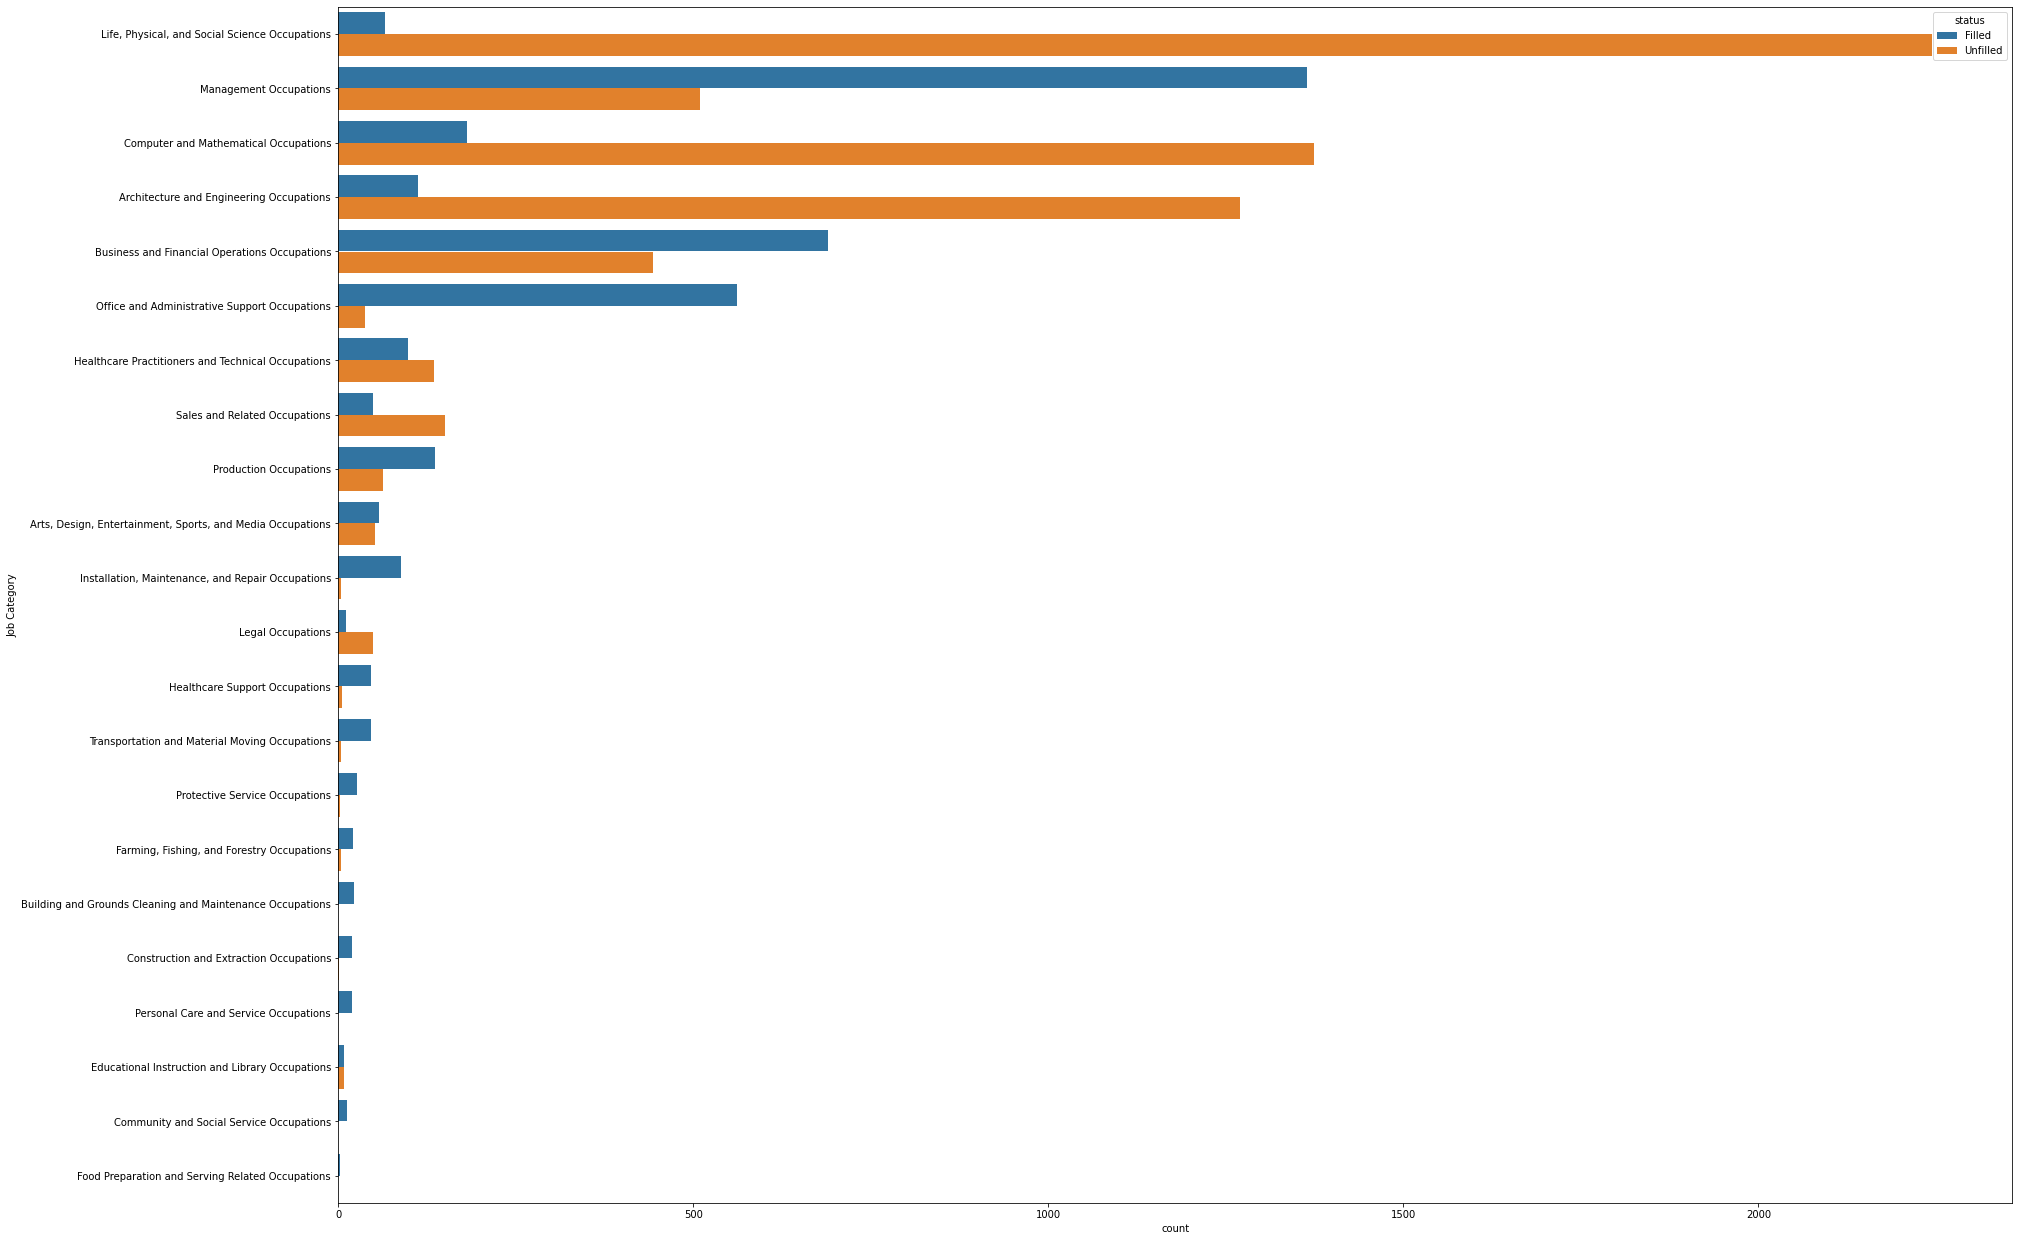

In [28]:
plot_filled_unfilled(bio_jobs_assignment, soc_level=2)

## All Software
use code 51913 for 'Internet Publishing and Broadcasting and Web Search Portals'

In [29]:
soft_naics_dict={'511210': 5000}
soft_soc_dict= job_map.get_employees_by_soc(soft_naics_dict, as_dict=True)
soft_jobs_assignment, soft_jobs_assignment_successful = job_sim(soft_soc_dict)

Number of jobs created: 4995
Creating SOC mat jobs
Creating SOC mat candidates
Attempting to match 4995 jobs from 13649 local candidates
	 Matched 2345 jobs locally


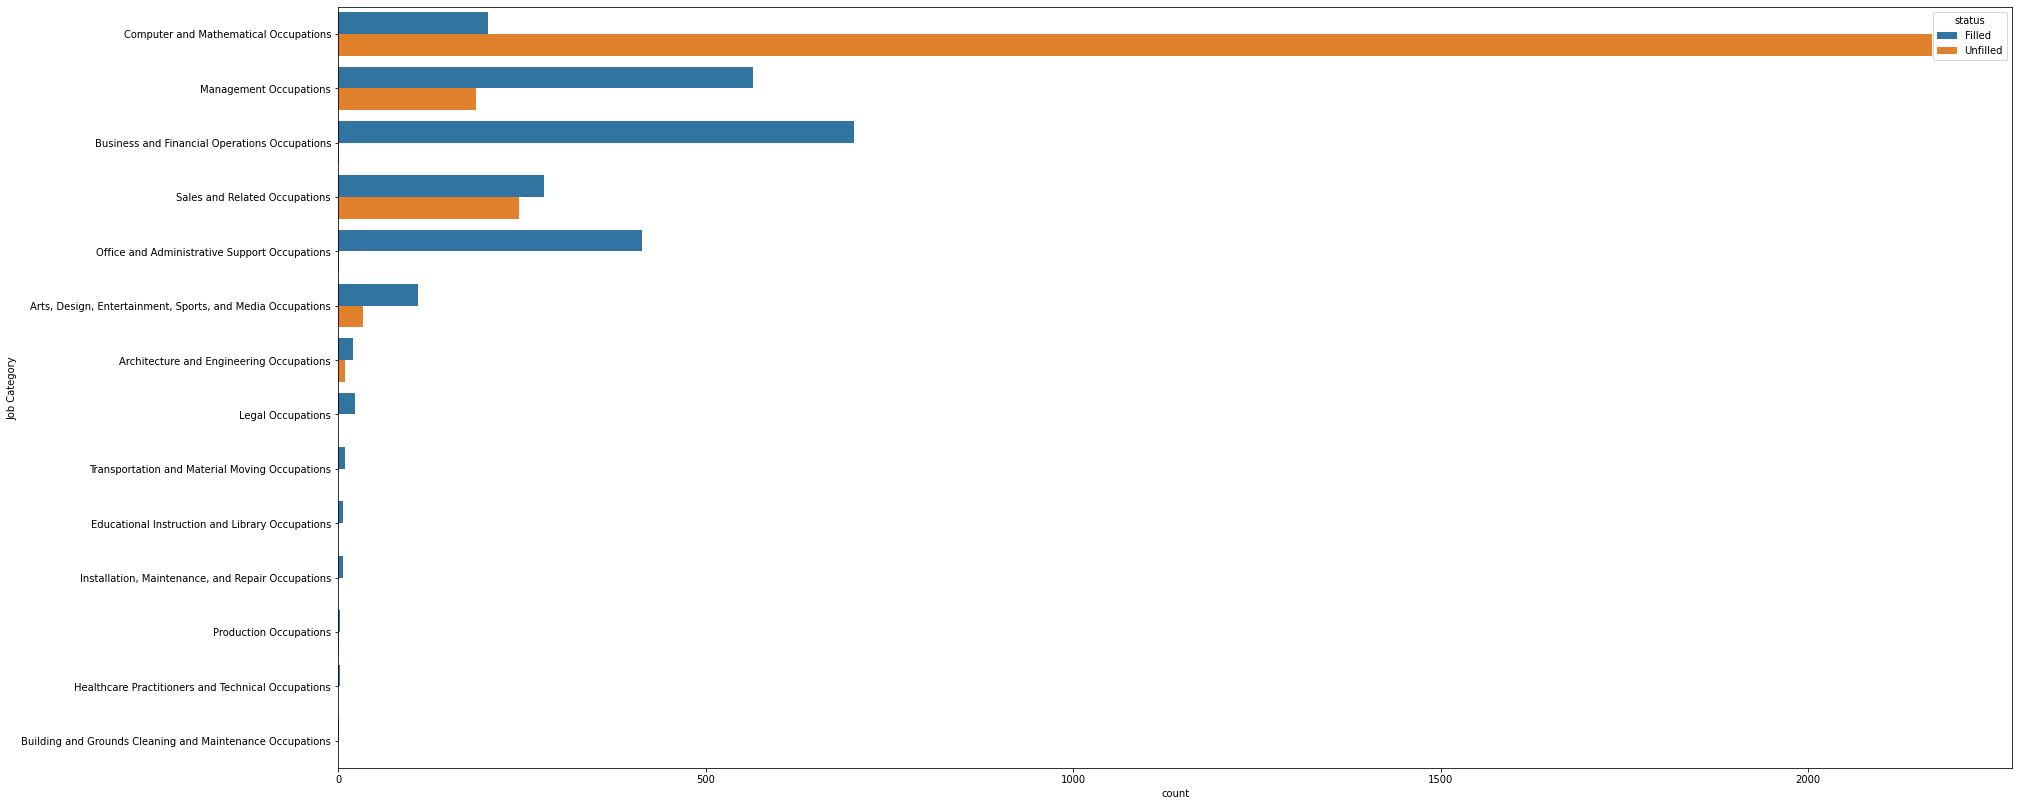

In [30]:
plot_filled_unfilled(soft_jobs_assignment, soc_level=2)

# Custom SOC distribution
randomly chosen distribution of SOC codes

In [31]:
custom_soc_props= {'431011': 0.5, '173027': 0.5}
custom_soc_dict= {s : int(10000* custom_soc_props[s]) for s in custom_soc_props}

In [32]:
custom_soc_dict

{'431011': 5000, '173027': 5000}

In [33]:
custom_jobs_assignment, custom_jobs_assignment_successful = job_sim(custom_soc_dict)

Number of jobs created: 10000
Creating SOC mat jobs
Creating SOC mat candidates
Attempting to match 10000 jobs from 13649 local candidates
	 Matched 487 jobs locally


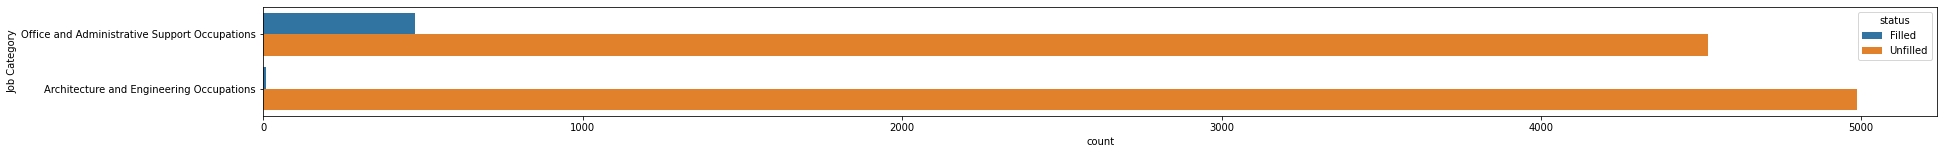

In [34]:
plot_filled_unfilled(custom_jobs_assignment, soc_level=2)

# Viz transitions

In [35]:
import plotly.graph_objects as go
import plotly

def viz_transitions(jobs_assignment_successful):
    job_od=jobs_assignment_successful.groupby(
        ['soc_old', 'soc_new']).size().reset_index(drop=False)
    source_labels=[get_soc_description(s) + '_s' for s in job_od['soc_old'].unique()]
    target_labels=[get_soc_description(t) + '_t' for t in job_od['soc_new'].unique()]
    all_labels=source_labels+target_labels
    value=list(job_od[0])

    source=[all_labels.index(get_soc_description(s) + '_s') for s in job_od['soc_old']]
    target=[all_labels.index(get_soc_description(t) + '_t') for t in job_od['soc_new']]

    fig = go.Figure(data=[go.Sankey(textfont = dict(color="white"),
        node=dict(
            thickness=10,  # default is 20
            line=dict(color="white", width=0.5),
            label=[l.split('_')[0] for l in all_labels],
            color="blue"
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            label=[l.split('_')[0] for l in all_labels],
            hovertemplate='%{value} from %{source.label} to %{target.label}.<br />'
        ))])

    fig.update_layout(
        width=1000,
        height=len(source)*30,
    plot_bgcolor = 'black',
    paper_bgcolor = 'black')

    fig.show(renderer='browser')

In [36]:
viz_transitions(custom_jobs_assignment_successful)